# Single-qubit resonant drive amplitude scan

In [1]:
import os
import pprint
import logging
import socket
if socket.gethostname() == 'iutgpu05.iut.icepp.s.u-tokyo.ac.jp':
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
import numpy as np
import h5py
import qutip as qtp
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from IPython.display import Math

from qiskit import IBMQ, pulse
from qiskit.tools.monitor import job_monitor

from qudit_sim import find_heff, parallel_map, run_pulse_sim, Gaussian, Sequence
from qudit_sim.heff import heff_expr, plot_amplitude_scan

twopi = np.pi * 2.

## Study general $H_{\mathrm{eff}}$ behavior with a dummy parameter set

In [2]:
params = {
    'wq0': 30.e+9,
    'wq1': 32.e+9,
    'delta0': -2.e+9,
    'delta1': -1.8e+9,
    'jq0q1': 10.e+6,
    'omegad0': 1.5e+9,
    'omegad1': 1.2e+9
}

## First, confirming the previous finding that num_sim_levels=3 and 4 give similar results for comp_dim=2

In [3]:
heff_3 = find_heff(
    qubits=0,
    params=params,
    drive_def={0: {'frequency': params['wq0'], 'amplitude': 0.3}},
    num_sim_levels=3,
    log_level=logging.INFO
)

Math(heff_expr(heff_3))

INFO:qudit_sim.find_heff:Running a square pulse simulation for 100 cycles
INFO:qudit_sim.pulse_sim:Instantiated a Hamiltonian generator for 1 qubits and 3 levels
INFO:qudit_sim.pulse_sim:Number of interaction terms: 0
INFO:qudit_sim.pulse_sim:Adding a drive with frequency 30000000000.000000 and envelope 0.3
INFO:qudit_sim.pulse_sim:Number of drive terms: 2
INFO:qudit_sim.pulse_sim:Using 1000 time points from 0.000e+00 to 3.142e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 3 terms generated. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 5.179978 seconds.
INFO:qudit_sim.heff.maximize_fidelity:Starting maximization loop..
INFO:qudit_sim.heff.maximize_fidelity:Done after 641 steps.


<IPython.core.display.Math object>

In [4]:
heff_4 = find_heff(
    qubits=0,
    params=params,
    drive_def={0: {'frequency': params['wq0'], 'amplitude': 0.3}},
    num_sim_levels=4,
    log_level=logging.INFO
)

Math(heff_expr(heff_4))

INFO:qudit_sim.find_heff:Running a square pulse simulation for 100 cycles
INFO:qudit_sim.pulse_sim:Instantiated a Hamiltonian generator for 1 qubits and 4 levels
INFO:qudit_sim.pulse_sim:Number of interaction terms: 0
INFO:qudit_sim.pulse_sim:Adding a drive with frequency 30000000000.000000 and envelope 0.3
INFO:qudit_sim.pulse_sim:Number of drive terms: 4
INFO:qudit_sim.pulse_sim:Using 1000 time points from 0.000e+00 to 1.571e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 5 terms generated. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.934754 seconds.
INFO:qudit_sim.heff.maximize_fidelity:Starting maximization loop..
INFO:qudit_sim.heff.maximize_fidelity:Done after 251 steps.


<IPython.core.display.Math object>

## Simulator $H_{\mathrm{eff}}$ amplitude scan from -1 to 1

In [5]:
run_amplitude_scan = True
amplitudes = np.linspace(-1., 1., 40)

if run_amplitude_scan:
    drive_def = list({0: {'frequency': params['wq0'], 'amplitude': amp}} for amp in amplitudes)

    heffs = find_heff(
        qubits=0,
        params=params,
        drive_def=drive_def,
        num_sim_levels=3,
        save_result_to='amplitude_scan')
    
else:
    heffs = np.empty(amplitudes.shape + (4,), dtype=np.complex128)

    for iamp in range(amplitudes.shape[0]):
        with h5py.File(f'amplitude_scan/heff_{iamp}.h5', 'r') as source:
            heffs[iamp] = source['heff_coeffs'][()]

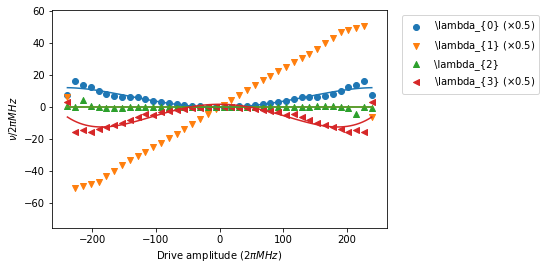

In [6]:
fig, exprs = plot_amplitude_scan(amplitudes * params['omegad0'], heffs)

## Get the reference backend params and default pulse schedule

In [7]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibm_kawasaki')

params = backend.configuration().hamiltonian['vars']
dt = backend.configuration().dt

x_instr = backend.defaults().instruction_schedule_map.get('x', 0).instructions
ref_pulse = x_instr[0][1].pulse
print(ref_pulse)

Drag(duration=160, amp=(0.1798150396292341+0j), sigma=40, beta=-1.0569687519983744, name='Xp_d0')


In [8]:
params = {
    'wq0': 33924495543.952213,
    'wq1': 33023338321.77772,
    'delta0': -2118378781.9719706,
    'delta1': -2141932002.0128999,
    'jq0q1': 13027010.077103492,
    'omegad0': 1053863739.3980201,
    'omegad1': 1305137153.295158,
}
dt = 0.22e-9
ref_pulse = pulse.Drag(duration=160, amp=(0.17985363422777756+0j), sigma=40, beta=-1.07194080464718, name='Xp_d0')

## Simulator Gaussian pulse amplitude scan

In [9]:
amplitudes = np.linspace(-0.2, 0.2, 20)
duration = ref_pulse.duration * dt

drive_def = list({0: {'frequency': params['wq0'], 'amplitude': Gaussian(0., duration, amp, ref_pulse.sigma * dt)}} for amp in amplitudes)

tlist = np.arange(0., duration, dt)

results = parallel_map(
    run_pulse_sim,
    args=drive_def,
    arg_position=2,
    common_args=(0, params),
    common_kwargs={'psi0': qtp.basis(3, 0), 'tlist': tlist})

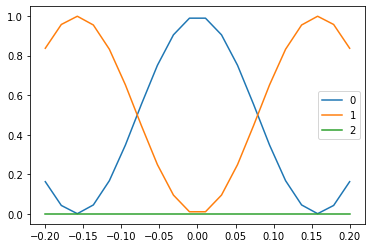

In [10]:
probs = np.array([np.square(np.abs(np.squeeze(result.states[-1]))) for result in results])

plt.plot(amplitudes, probs, label=['0', '1', '2'])
plt.legend()

## IBMQ amplitude scan

In [11]:
schedules = []

for amp in amplitudes:
    with pulse.build(backend=backend, default_alignment='sequential') as sched:
        drive_chan = pulse.drive_channel(0)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=amp), drive_chan)
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])

    schedules.append(sched)

In [12]:
shots = 4096

#job = backend.run(schedules, shots=shots)
#job_monitor(job)

job = backend.retrieve_job('623c2910a2f72d3bebdab1d8')

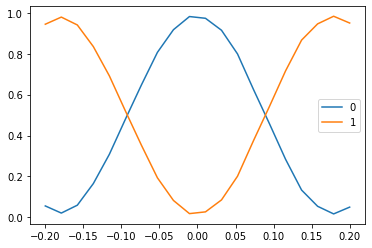

In [13]:
counts = job.result().get_counts()

exp_probs = np.array([[cnt.get('0', 0), cnt.get('1', 0)] for cnt in counts], dtype=float) / shots

plt.plot(amplitudes, exp_probs, label=['0', '1'])
plt.legend()

So the `amp` parameter in qiskit.pulse is more or less really the factor applied to `omegadX`.

## Confirming the $R_{z}$ component in the Gaussian pulse

### Simulator

In [14]:
amplitudes = np.linspace(0.05, 0.8, 16)
drive_def = []
for amp in amplitudes:
    sequence = Sequence([
        Gaussian(0., 160. * dt, amp, 40. * dt),
        Gaussian(160. * dt, 160. * dt, -amp, 40. * dt),
        Gaussian(320. * dt, 160. * dt, amp, 40. * dt),
        Gaussian(480. * dt, 160. * dt, -amp, 40. * dt)
    ])
    
    drive_def.append({0: {'frequency': params['wq0'], 'amplitude': sequence}})
    
tlist = np.arange(0., 640. * dt, 0.1 / (params['wq0'] / twopi))
    
results = parallel_map(
    run_pulse_sim,
    args=drive_def,
    arg_position=2,
    common_args=(0, params),
    common_kwargs={'psi0': qtp.basis(3, 0), 'tlist': tlist})

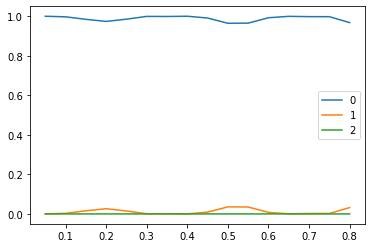

In [15]:
probs = np.array([np.square(np.abs(np.squeeze(result.states[-1]))) for result in results])

plt.plot(amplitudes, probs, label=['0', '1', '2'])
plt.legend()

### IBMQ

In [16]:
schedules = []

for amp in amplitudes:
    with pulse.build(backend=backend, default_alignment='sequential') as sched:
        drive_chan = pulse.drive_channel(0)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=amp), drive_chan)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=-amp), drive_chan)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=amp), drive_chan)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=-amp), drive_chan)
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])

    schedules.append(sched)

In [17]:
shots = 4096

#job = backend.run(schedules, shots=shots)
#job_monitor(job)

job = backend.retrieve_job('623d13fbe32b42bc0aecda5b')

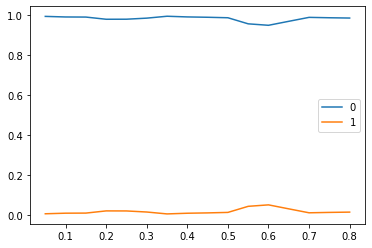

In [18]:
counts = job.result().get_counts()

exp_probs = np.array([[cnt.get('0', 0), cnt.get('1', 0)] for cnt in counts], dtype=float) / shots

plt.plot(amplitudes, exp_probs, label=['0', '1'])
plt.legend()

I guess we are seeing it..